# Denoising CIFAR-10 with  convolutional autoencoders in TensorFlow 2.0

Autoencoders are neural network models that attempt to learn how to copy their input to their output and are composed of an encoder, used for pattern recognition and a decoder, used for generating an output. In particular an autoencoder learns how to create efficient internal representations of input data called ••codings** which typically have a lower dimension than the input, therefore autoencoders can be used for compression. Since the internal representation is smaller than the input, the model us considerd to be **incomplete** and the encoder must find patterns in the input to represent the input, and the decoder must find patterns in the encoding to generate an output. A simple autoencoder could be a multilayer perceptron with the same number of outputs ans inputs, and a single layer with less nodes than the input/output layers. We use convolutional layers, to recognise patterns in the data and to reconstruct images. 

In this project we artificially add noise to the the CIFAR-10 datset and use these images as training instances, while using the 'clean' images as labels. This way we can make the autoencoder learn how to represent the clean images in the presence of noise and thus generate clean images from noisy ones. The best model considered so far has an accuracy of 72% after training for 5 epochs and shows no signs of overfitting. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(type(y_train[0]))

(50000, 32, 32, 3)
(50000, 1)
<class 'numpy.ndarray'>


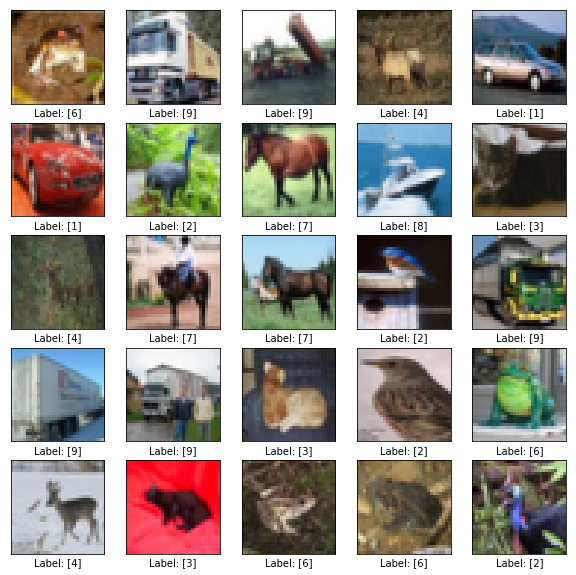

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.xlabel('Label:'+' '+str(y_train[i]))
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

We can randomly sample values from a normal distribution and add them to the data to generate noise.

In [5]:
def noise(data,sigma=0.1):
    
    noise = np.random.normal(loc=0.0, scale=sigma, size=data.shape)
    data = data/255.0 + noise
    
    #Clip maps any values that below/above 0/1 onto 0 and 1
    data = np.clip(data, 0., 1.)
    return data

x_train_noise = noise(x_train)
x_test_noise = noise(x_test)

#Scale x_train and x_test for training later 
x_train=x_train/255.0
x_test=x_test/255.0


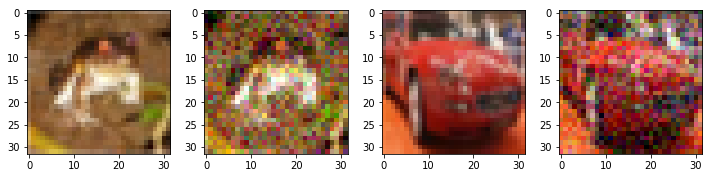

In [6]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(10,10))
ax[0].imshow(x_train[0])
ax[1].imshow(x_train_noise[0])
ax[2].imshow(x_train[5])
ax[3].imshow(x_train_noise[5])
plt.tight_layout()
plt.show()

In [7]:
print(x_train.shape)
print(x_test_noise.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [37]:
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2),padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2),padding='same')) #the representation here is (6,6,64)
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())

# DeConv1
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',padding='same'))
model.add(layers.BatchNormalization())


print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 8)          

In [38]:
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

Autoencoder = model.fit(x_train_noise,x_train,epochs=5,batch_size=64)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 319s 6ms/sample - loss: 0.2029 - accuracy: 0.5029
Epoch 2/5
50000/50000 [==============================] - 318s 6ms/sample - loss: 0.0119 - accuracy: 0.5916
Epoch 3/5
50000/50000 [==============================] - 321s 6ms/sample - loss: 0.0083 - accuracy: 0.6667
Epoch 4/5
50000/50000 [==============================] - 323s 6ms/sample - loss: 0.0066 - accuracy: 0.7062
Epoch 5/5
50000/50000 [==============================] - 324s 6ms/sample - loss: 0.0058 - accuracy: 0.7199


In [39]:
model.evaluate(x_train_noise,x_train,batch_size=64)

50000/50000 [==============================] - 73s 1ms/sample - loss: 0.0106 - accuracy: 0.7200


[0.01060935607612133, 0.7200323]

In [ ]:
predictions = model.predict(x_test_noise)
predictions = np.clip(predictions, 0., 1.)

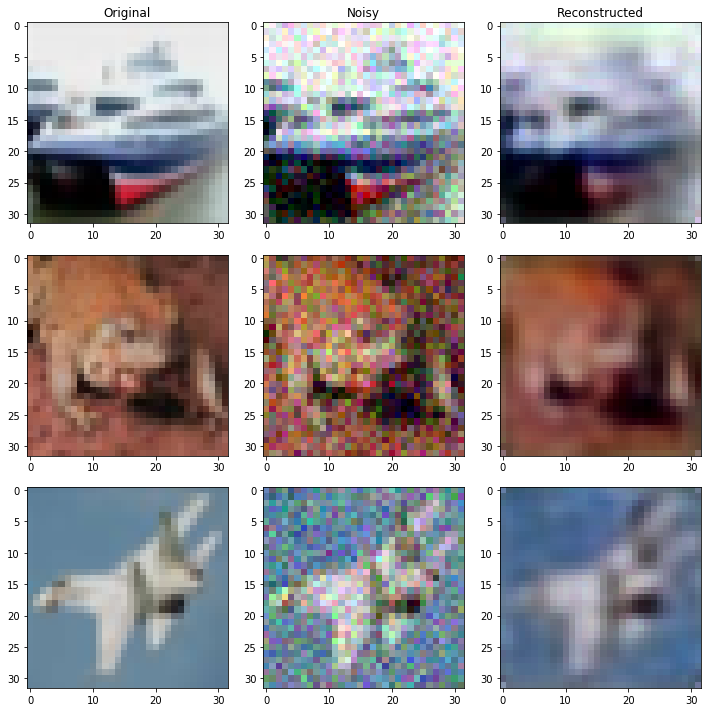

In [42]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax[0,0].imshow(x_test[1])
ax[0,1].imshow(x_test_noise[1])
ax[0,2].imshow(predictions[1])
ax[1,0].imshow(x_test[5])
ax[1,1].imshow(x_test_noise[5])
ax[1,2].imshow(predictions[5])
ax[2,0].imshow(x_test[10])
ax[2,1].imshow(x_test_noise[10])
ax[2,2].imshow(predictions[10])
ax[0,0].set_title('Original')
ax[0,1].set_title('Noisy')
ax[0,2].set_title('Reconstructed')
plt.tight_layout()
plt.show()

 When evaluated on the test set the model has the same accuracy of 72% on as on the training set which indicates the model is not overfitting. The generated images bear some resmblence to the originals but are missing detail.

***

## Remove 2 convolution layers

In [9]:
reduced_convolution_model = tf.keras.models.Sequential()

reduced_convolution_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
reduced_convolution_model.add(layers.BatchNormalization())
reduced_convolution_model.add(layers.MaxPooling2D((2, 2),padding='same'))
reduced_convolution_model.add(layers.Conv2D(8, (3, 3), activation='relu',padding='same'))
reduced_convolution_model.add(layers.BatchNormalization())
reduced_convolution_model.add(layers.MaxPooling2D((2, 2),padding='same')) #the representation here is (6,6,64)


# DeConv1
reduced_convolution_model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
reduced_convolution_model.add(layers.BatchNormalization())
reduced_convolution_model.add(layers.UpSampling2D((2, 2)))

reduced_convolution_model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
reduced_convolution_model.add(layers.BatchNormalization())
reduced_convolution_model.add(layers.UpSampling2D((2, 2)))
reduced_convolution_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',padding='same'))
reduced_convolution_model.add(layers.BatchNormalization())
 
reduced_convolution_model.build()
print(reduced_convolution_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         2312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)          

In [11]:
reduced_convolution_model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
Autoencoder = reduced_convolution_model.fit(x_train_noise,x_train,epochs=5,batch_size=64)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 119s 2ms/sample - loss: 0.2094 - accuracy: 0.4873
Epoch 2/5
50000/50000 [==============================] - 118s 2ms/sample - loss: 0.0135 - accuracy: 0.5707
Epoch 3/5
50000/50000 [==============================] - 141s 3ms/sample - loss: 0.0102 - accuracy: 0.6396
Epoch 4/5
50000/50000 [==============================] - 119s 2ms/sample - loss: 0.0087 - accuracy: 0.6748
Epoch 5/5
50000/50000 [==============================] - 118s 2ms/sample - loss: 0.0080 - accuracy: 0.6876


In [29]:
reduced_convolution_model.evaluate(x_train_noise,x_train,batch_size=64)

50000/50000 [==============================] - 23s 463us/sample - loss: 0.0162 - accuracy: 0.5761


[0.016230125543475152, 0.57609427]

In [12]:
reduced_convolution_predictions = reduced_convolution_model.predict(x_test_noise)

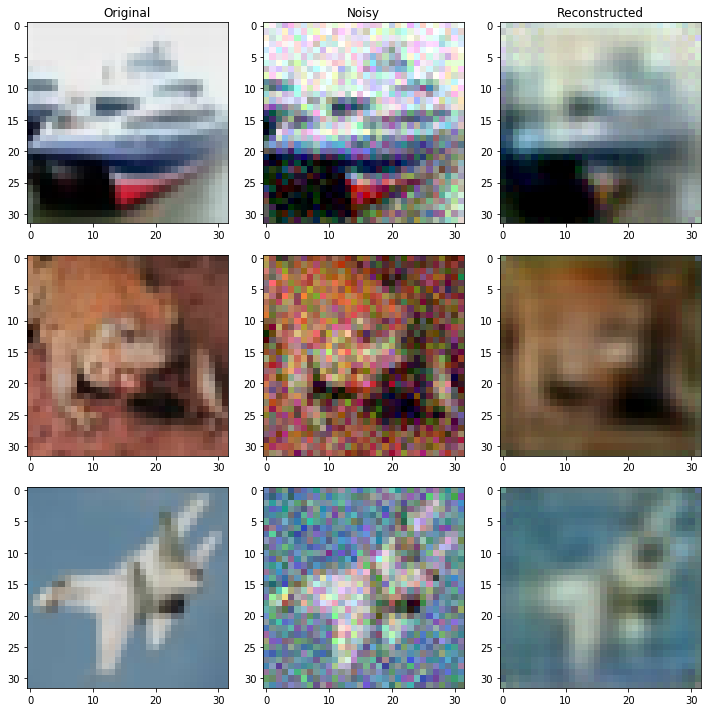

In [43]:
reduced_convolution_predictions = np.clip(reduced_convolution_predictions, 0., 1.)
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax[0,0].imshow(x_test[1])
ax[0,1].imshow(x_test_noise[1])
ax[0,2].imshow(reduced_convolution_predictions[1])
ax[1,0].imshow(x_test[5])
ax[1,1].imshow(x_test_noise[5])
ax[1,2].imshow(reduced_convolution_predictions[5])
ax[2,0].imshow(x_test[10])
ax[2,1].imshow(x_test_noise[10])
ax[2,2].imshow(reduced_convolution_predictions[10])
ax[0,0].set_title('Original')
ax[0,1].set_title('Noisy')
ax[0,2].set_title('Reconstructed')
plt.tight_layout()
plt.show()

The model is beginning to overfit the data, despite removing convolution layers, as the accuracy drops by 9% when evaluating on the test images. 

***

## Removing the batch normalisation layers

We will leave just one batch normalisation layer before the sigmoid function 

In [26]:
reduced_normalization_model = tf.keras.models.Sequential()

reduced_normalization_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
#model.add(layers.BatchNormalization())
reduced_normalization_model.add(layers.MaxPooling2D((2, 2),padding='same'))
reduced_normalization_model.add(layers.Conv2D(8, (3, 3), activation='relu',padding='same'))
#model.add(layers.BatchNormalization())
reduced_normalization_model.add(layers.MaxPooling2D((2, 2),padding='same')) #the representation here is (6,6,64)


# DeConv1
reduced_normalization_model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
#model.add(layers.BatchNormalization())
reduced_normalization_model.add(layers.UpSampling2D((2, 2)))

reduced_normalization_model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
reduced_normalization_model.add(layers.BatchNormalization())
reduced_normalization_model.add(layers.UpSampling2D((2, 2)))
reduced_normalization_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',padding='same'))
#model.add(layers.BatchNormalization())
          
print(reduced_normalization_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 8)         2312      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)       

In [27]:
reduced_normalization_model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
Autoencoder =reduced_normalization_model.fit(x_train_noise,x_train,epochs=5,batch_size=64)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 102s 2ms/sample - loss: 0.0113 - accuracy: 0.6442
Epoch 2/5
50000/50000 [==============================] - 103s 2ms/sample - loss: 0.0072 - accuracy: 0.7124
Epoch 3/5
50000/50000 [==============================] - 102s 2ms/sample - loss: 0.0065 - accuracy: 0.7315
Epoch 4/5
50000/50000 [==============================] - 105s 2ms/sample - loss: 0.0061 - accuracy: 0.7386
Epoch 5/5
50000/50000 [==============================] - 102s 2ms/sample - loss: 0.0059 - accuracy: 0.7418


In [31]:
reduced_normalization_model.evaluate(x_test,x_test_noise,batch_size=64)

10000/10000 [==============================] - 4s 428us/sample - loss: 0.0143 - accuracy: 0.5386


[0.014252008748054504, 0.5385617]

In [ ]:
reduced_normalization_predictions = reduced_normalization_model.predict(x_test_noise)

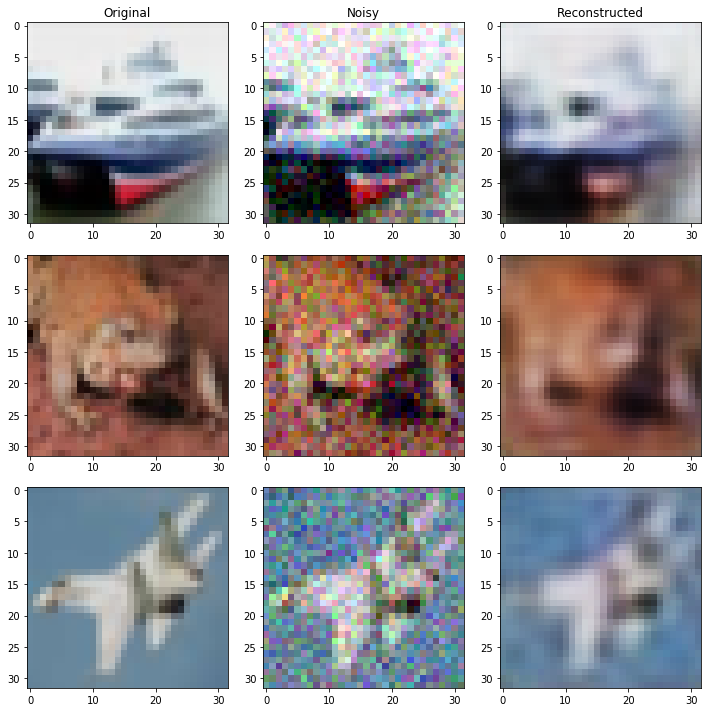

In [45]:
reduced_normalization_predictions = np.clip(reduced_normalization_predictions, 0., 1.)
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax[0,0].imshow(x_test[1])
ax[0,1].imshow(x_test_noise[1])
ax[0,2].imshow(reduced_normalization_predictions[1])
ax[1,0].imshow(x_test[5])
ax[1,1].imshow(x_test_noise[5])
ax[1,2].imshow(reduced_normalization_predictions[5])
ax[2,0].imshow(x_test[10])
ax[2,1].imshow(x_test_noise[10])
ax[2,2].imshow(reduced_normalization_predictions[10])
ax[0,0].set_title('Original')
ax[0,1].set_title('Noisy')
ax[0,2].set_title('Reconstructed')
plt.tight_layout()
plt.show()

As expected, removing the batch normalisation layers causes overfitting to increase, however the generated images are not too dissimilar to the images generated by the first model.